&nbsp;

# 21 - Implémentation du modèle SINDy

---

&nbsp;

“Discovering governing equations from data by sparse identification of nonlinear dynamical systems”
Proceedings of the National Academy of Sciences, 2016 -> BRUNTON, PROCTOR& KUTZ (PNAS)

> ### Qu'est-ce que la méthode SINDy et comment l'implémenter pour notre jeu de donnée ?

La méthode SINDy (ou *Sparse Identification of Non-linear Dynamic*) cherche à représenter l'évolution temporelle d'un état $z(t)$ sous la forme d'une fonction non-linéaire $f$, soit :

$$
\frac{d}{dt}z(t) = f(z(t))
$$

Exactement la forme que l'on cherche à approximer. On admet que cette équation consistue un système dynamique pour mesurer $z(t)$, où l'état est en fait un vecteur comme suit :

$$
z(t) = [z_1(t), z_2(t). \dots, z_n(t)]^{\perp} 
$$

On peut aisément identifier que $z(t)$ correspond bien à notre état réduit actuel déjà préparé. La fonction $f(z(t))$ vient contraindre comment le système évolue dans le temps. L'idée clé derrière SINDy est que la fonction est souvent répandue dans l'espace d'un ensemble approprié de fonctions de base. On pourrait donner l'exemple suivant :

$$
\frac{d}{dt}z(t) = f(x) = 
\begin{bmatrix}
   f_1(x) \\
   f_2(x)
\end{bmatrix} = 
\begin{bmatrix}
   1 - x_1²x_2 + 8x_1 \\
   1 - 4x_1³
\end{bmatrix}
$$

On dit que la fonction est *parcimonieuse*(ou *sparse*) car la descriptivité est approximée en *sets* de polynômes de deux variables d'une manière que si on écrivait nos fonctions de la forme d'une expansion de fonctions composantes $f_y(x) = \sum^{\infty}_{i=0}\sum^{\infty}_{j=0} a_{i,j}x_1^i x_2^j$, alors il y aurait très peu de coefficients $a_{i,j}$ qui serait non-nuls. 

SINDy emploie une régression parcimonieuse pour chercher une combinaison linéaire de fonctions de base qui capture au mieux la dynamique comporementale du système physique.

Maintenant que nous avons connaissance des fondamentaux de la méthode, démarrons l'implémentation par les basiques.

In [2]:
# We import all libs we will need to implement properly SINDy method
using NPZ
using LinearAlgebra
using Statistics
using ModelingToolkit
using OrdinaryDiffEq
using Printf
using Statistics
using Plots

# We import our reduced state (build by selection)
data = npzread("data/processed/sstReducedState2COPERNICUS20102019.npz")

# We extract main parameters from it
Z  = Float64.(data["Z"]) #(time, state)
dZ = Float64.(data["dZ"]) # We cast as Float64 to avoid futures errors of type with lib imported functions
splitMask = Int.(data["split"])

# We permut to a preferrable order
Z  = permutedims(Z) #(state, time) 
dZ = permutedims(dZ)

nState, T = size(Z) # Thanks to size(x) function we can extract bounds

# We seek for bounds indexes to delimit test and train sets
# split is a shape of (0, 0, 0, 0, ..., 1, 1, 1)
trainIdx = findall(splitMask .== 0) 
testIdx  = findall(splitMask .== 1)

# We properly define to work easily with our state later
ZTrain  = Z[:, trainIdx]
dZTrain = dZ[:, trainIdx]
ZTest   = Z[:, testIdx]
dZTest  = dZ[:, testIdx];

Ensuite, par rigueur, nous allons normaliser de nouveau pour éviter toute sparsité biaisé (étant donné que nous travaillerons avec un seuil, nous voulons que les coefficients soient sur un pied d'égalité).

In [3]:
# we normalize again "state by state" to ensure sparse regression will operate correctly (as state-wise)
# of course we compute mean and standard error only on train set to avoid any anticipation biais
μ = mean(ZTrain; dims=2)
σ = std(ZTrain; dims=2) .+ 1e-8

ZTrainN = (ZTrain .- μ) ./ σ
ZTestN  = (ZTest  .- μ) ./ σ

dZTrainN = dZTrain ./ σ
dZTestN  = dZTest  ./ σ;

Entrons désormais dans le coeur de la méthode SINDy.

En l'état, nous avons pour le moment les deux matrices suivantes (aggrégées par nos données): 

$$
Z = \begin{bmatrix}
   z_1(t_1) & z_2(t_1) & \dots & z_n(t_1) \\
   z_1(t_2) & z_2(t_2) & \dots & z_n(t_2) \\
   \vdots & \vdots & & \vdots \\
   z_1(t_m) & z_2(t_m) & \dots & z_n(t_m) \\
\end{bmatrix}, \space \space \space \dot{Z} = \begin{bmatrix}
   \dot{z}_1(t_1) & \dot{z}_2(t_1) & \dots & \dot{z}_n(t_1) \\
   \dot{z}_1(t_2) & \dot{z}_2(t_2) & \dots & \dot{z}_n(t_2) \\
   \vdots & \vdots & & \vdots \\
   \dot{z}_1(t_m) & \dot{z}_2(t_m) & \dots & \dot{z}_n(t_m) \\
\end{bmatrix}
$$

L'hypothèse clé de la méthode est que le champ de vecteurs est parcimonieux dans une base de fonctions appropriée (l'hypothèse est physique, pas statistique, on imagine décrire le système par des lois simples). Mathématiquement cela correspond à

$$f(z) \in \text{span}[\theta_1(z), \theta_2(z), \dots, \theta_p(z)]$$

mais avec peu de termes actifs. Autrement dit :

$$
\dot{z}(t) = \overset{p}{\underset{j=1}{\sum}} \xi_j \theta_j(z(t)), \space ||\xi||_0 \ll p
$$

&nbsp;

In [4]:
# We declare symbolic variables (nState times so it match dimensions correctly)
@variables x[1:nState]

# We build the local polynomial lib
basis = Num[]
push!(basis, 1) # we start by pushing 1

#then we push several ways to arrange our symbolic variables

# linearly
for i in 1:nState
    push!(basis, x[i])
end

# quadraticly local
for i in 1:nState
    push!(basis, x[i]^2)
    if i < nState
        push!(basis, x[i] * x[i+1])
    end
end

nbasis = length(basis)
println("Reduced library size = ", nbasis)
println("Lib :", basis)

Reduced library size = 51
Lib :Num[1, x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9], x[10], x[11], x[12], x[13], x[14], x[15], x[16], x[17], x[1]^2, x[1]*x[2], x[2]^2, x[2]*x[3], x[3]^2, x[3]*x[4], x[4]^2, x[4]*x[5], x[5]^2, x[5]*x[6], x[6]^2, x[6]*x[7], x[7]^2, x[7]*x[8], x[8]^2, x[8]*x[9], x[9]^2, x[10]*x[9], x[10]^2, x[10]*x[11], x[11]^2, x[11]*x[12], x[12]^2, x[12]*x[13], x[13]^2, x[13]*x[14], x[14]^2, x[14]*x[15], x[15]^2, x[15]*x[16], x[16]^2, x[16]*x[17], x[17]^2]


Pour cela, nous devons définir une bibliothèque de candidats $\Theta(x)$ de la forme

$$
\Theta(z) = [\theta_1(z) \space \theta_2(z) \space \dots \space \theta_p(z)]
$$

où chaque terme peut être une constante, un état clé, un couplage d'états, et plus. Pour chaque instant $t_k$, on évalue : 

$$
\Theta(z(t_k)) \in \mathbb{R}^p
$$

In [5]:
# we build Θ function
# ModelingToolkitBase permit us to perform symbolical-numeric computation, it is unevitable when sparsifying or parallelizing
# See following link for more details about the lib : https://juliapackages.com/p/modelingtoolkit

# Here we initialize the 0 function using our candidates dict
ΘBase = ModelingToolkit.build_function( #build_function method can be hard to find in documentation because it is low level API in the lib but it just compile a function for Julia without symbolic and very fastly
    basis, x;
    expression = Val(false)
)[1]

# Then we build Θ matrix
function buildΘ(Zmat, ΘBase, nbasis)
    Tloc = size(Zmat, 2) # we search for the time size of the matrix here
    Θ = zeros(Float64, Tloc, nbasis) # we preform a matrix of the right shape
    for t in 1:Tloc
        Θ[t, :] .= ΘBase(Zmat[:, t]) # we just apply 0 function to state matrix 
    end
    return Θ
end

ΘTrain = buildΘ(ZTrainN, ΘBase, nbasis)
ΘTest  = buildΘ(ZTestN,  ΘBase, nbasis)

println("ΘTrain :", ΘTrain)

ΘTrain :[1.0 -0.027307412431927452 0.1650844965528944 0.1349328597207983 -0.12966407428655888 0.21687781399185335 0.05749625098307566 0.27702741092188354 0.21816559265232743 0.18694745351062145 0.23029478644074403 -0.10469897647710996 -0.22626175125870973 0.08405386135467867 0.24984321101581025 -0.17161771374967336 0.01651266978400426 0.2116468547492219 0.000745694773727386 -0.004508030433486993 0.027252891002122602 0.02227532321545031 0.01820687663243263 -0.017495944346535418 0.01681277216059026 -0.028121260984546172 0.04703598620188494 0.012469661225936398 0.003305818877108829 0.015928037547556253 0.07674418640208212 0.06043784928471257 0.04759622581734126 0.040785501989988156 0.034949350374105966 0.04305302388186949 0.0530356886617879 -0.02411162842836052 0.010961875675354425 0.023689373772705354 0.05119438008265823 -0.01901817387016638 0.007065051608631545 0.021000286619130643 0.06242163009069069 -0.04287752067041056 0.029452639672664822 -0.002833866636234124 0.00027266826339556735

Excessive output truncated after 524300 bytes.

 0.02474144458334009 0.007248413332011592 0.019373279702091212 0.051780155079994436 0.053074330440020696 0.054400851973207535; 1.0 -0.10765069265222328 0.006134513336270573 -0.228453478790839 0.08307563001011747 -0.18063211985455827 -0.16424101040841477 -0.3866801355524169 -0.053389040032865265 -0.36209925315816927 -0.365535241699714 -0.04065382211030215 0.08951747801713911 -0.13235426165048306 -0.1637780226136229 0.1374426147320702 -0.025749884241215715 -0.008647789363717226 0.01158867162850344 -0.0006603846097338283 3.763225387288152e-5 -0.0014014509123598084 0.05219099197163632 -0.01897891667855196 0.006901560301577931 -0.015006127156980477 0.0326279627231515 0.02966720187712653 0.02697510949997701 0.06350873616799174 0.14952152723083553 0.020644481236921756 0.0028503895956308897 0.019332131522732113 0.13111586913770396 0.13236003802245733 0.13361601292446834 0.014860404691106473 0.0016527332521760918 -0.0036392276270716564 0.008013378870548983 -0.011848019707771794 0.01751765057704

Maintenant que l'on a nos paramètres initiaux prêts, ils ne nous manquent plus qu'à résoudre le problème fondamental et inverse, nous cherchons une solution à

$$
\dot{Z} = \Theta(Z)\Xi
$$

où $\Xi$ est notre matrice solutionnante inconnue, avec $\Xi = \begin{bmatrix} | & | & & | \\ \xi^{(1)} & \xi^{(2)} & \dots & \xi^{(n)} \\ | & | & & | \end{bmatrix} \in \mathbb{R}^{p\times n}$.

Chaque colonne correspond à une équation différentielle : 

$$
\dot{z}_i = \Theta(z)\xi^{(i)}
$$

Le problème que l'on doit résoudre par la machine est donc (sans contrainte)

$$
\underset{\Xi}{\text{min}} \space || \Theta\Xi - \dot{Z} ||_2^2
$$

mais le problème est finalement mal posé, car la minimisation dans ces conditions mène à une solution dense, instable et non-interprétable, c'est là qu'intervient le twist de la méthode SINDy.

Si nous rajoutions une contrainte filtrant ainsi une partie majoritaire de ce qui rend cette solution caractéristiquement médiocre, nous pourrions obtenir un résultat convenable. Le problème est donc toujours le même mais sous la contrainte que $||\Xi||_0$ est petit.

&nbsp;

SINDy n'essaie pas de résoudre directement la minimisation de la contrainte citée ci-dessus. Il utilise une heuristique itérative appelée *Sequential Thresholded Least Squares* (ou LSTLSQ).

Algorithmiquement, cela correspond à suivre la méthode suivante pour chaque équation $\dot{z}_i$ :

1. On minimise par moindres carrés, soit : $\xi^{(0)} = \text{arg} \space \underset{\xi}{\text{min}} ||\Theta \xi - \dot{z}_i||_2^2$
2. On fixe un seuil dur arbitrairement choisi et qui peut être ajusté : $\xi^{(k)} = \left \{
   \begin{array}{r c l}
      0 & \text{si} \space \space |\xi^{(k-1)}| < \lambda \\
      \xi^{(k-1)} & \text{sinon}
   \end{array}
   \right . $

3. On peut ensuite régresser de manière restreinte avec les coefficients non nuls : $\xi^{(k)} = \text{arg} \space \underset{\xi \in \mathcal{S}}{\text{min}} ||\Theta_\mathcal{S} \xi - \dot{z}_i||_2^2$
4. On répète jusqu'à convergence.


In [6]:
# STLSQ from scratch
function stlsq(Θ, y; λ=0.1, nIter=10) 
    # Θ, theta matrix prebuild
    # y, our differentiate state
    # λ, lambda, our sparsity threshold
    # nIter, number of iteration to find convergence (STEP 4 parameter) that can be adjusted

    ξ = Θ \ y # simple way to compute STEP 1
    for _ in 1:nIter
        small = abs.(ξ) .< λ # we detect insignificant coefficients for sparsity
        ξ[small] .= 0.0 # we replace them by 0 (STEP 2)
        big = .!small # we designate that coefficients we are working with are the others
        if any(big)
            ξ[big] = Θ[:, big] \ y # restricted regression (STEP 3)
        end
    end # again and again to convergence (STEP 4)
    return ξ
end

stlsq (generic function with 1 method)

Par convénience, le *computing* via $\text{arg min}$ peut être simplifé par la manière dont nous l'avons codé dans la fonction pour les étapes 1 et 3. Julia résoud ces minimisations en cherchant les solutions comme : 
$$
\xi^{(0)} = (\Theta^T\Theta)^{-1}\Theta^{-1}\dot{z}
$$

&nbsp;

Ensuite, nous devons nous occuper de l'hyperparamètre critique de SINDy, λ, notre seuil de sparsité. 

S'il est trop petit, le modèle sera dense et sur-ajusté, s'il est trop grand, le modèle sera vide ou faux. De plus , il n'y a pas vraiment de valeur universelle, l'idée est donc d'explorer plusieurs valeurs et de comparer les modèles obtenus.

In [7]:
# we will pay attention to select an appropriate λ, so we sweep it
λList = [0.05, 0.1, 0.2, 0.5] # we choose some arbitrary lambda values
results = Dict{Float64,Any}() # pre initialize a dictionnary to store different results

for λ in λList # each iteration learn a complete SINDy model with a candidate sparsity parameter

    Ξ = zeros(Float64, nbasis, nState) # we initialize Xi matrix that will contain complete dynamic model

    for i in 1:nState
        Ξ[:, i] = stlsq(ΘTrain, dZTrainN[i, :]; λ=λ) # we complete the xi coefficient matrix
    end

    dZPred = (ΘTrain * Ξ)' # we rebuild predicted derivates

    rmseVal = sqrt(mean((dZPred .- dZTrainN).^2)) # we compute RMSE so we can check adjusted quality (does not guarantee stability but mesure local loyalty)
    sparsity = 100 * count(abs.(Ξ) .< 1e-12) / length(Ξ) # we evaluate sparsity counting relevant coefficients

    results[λ] = (Ξ=Ξ, rmse=rmseVal, sparsity=sparsity) # we store result

    @printf "λ = %.2f | RMSE = %.4f | Sparsity = %.1f%%\n" λ rmseVal sparsity # we print it
end

λ = 0.05 | RMSE = 0.2750 | Sparsity = 32.2%
λ = 0.10 | RMSE = 0.2758 | Sparsity = 56.1%
λ = 0.20 | RMSE = 0.2792 | Sparsity = 96.4%
λ = 0.50 | RMSE = 0.2795 | Sparsity = 100.0%


En plus de la RMSE, nous devons mesurer la composante de parcimonie de l'objet central de SINDy, la matrice $\Xi$. Ce qu'on veut mesurer c'est donc la sparsité de la matrice résultante.

> #### Combien de coefficients sont réellement utilisés ?

C'est l'idée intuitive qui représente ce qu'on cherche à mesurer. En observant notre matrice $\Xi$ :
- Si la matrice est dominée par des coefficients à zéro, le modèle sera simple (à tord ou à raison).
- Si la matrice est dominée par des coefficients non-nuls, le modèle sera complexe (de même).

&nbsp;

Dans l'article fondateur de la méthode SINDy, le problème fondamental est formulé, puis, la sparsité est implicitement définie comme le nombre de coefficients non nuls dans $\Xi$, ou inversement, le nombre de termes actifs dans l'équation. On peut ainsi déduire une équation mathématique simple pour déterminer la sparsité :

$$
\mathcal{S} = \frac{\# \{|\Xi_{ij}|\approx 0\}}{\# \{\Xi_{ij} \}}
$$

Expliquez plus simplement : on calcule le rapport entre le nombre de coefficients de la matrice à 0, et le nombre total de coefficients.

In [8]:
# here we seek for the best λ
valid = filter(kv -> kv[2].sparsity < 99.9, results) # we filter degen models (eliminate empty and zero ones)
bestλ = argmin(k -> valid[k].rmse, keys(valid)) # optimize to look for the best
best = valid[bestλ] # we fix

# print
println("\nBEST λ = ", bestλ)
println("RMSE = ", best.rmse)

Ξ = best.Ξ; # we restreint to the only one we choose


BEST λ = 0.05
RMSE = 0.2749612899979503


Afin de choisir au mieux notre seuil de sparsité, nous appliquons deux critères de sélection :
- On filtre grossièrement les modèles ultra-simples (parcimonie exagérée où l'extrême majorité des coefficients ont été forcé à zéro).
- On récupère l'argument de la matrice avec la meilleure RMSE. (À noter que la RMSE est très similaire pour l'ensemble des modèles, nous pourrons revenir plus tard vers ce détail).

In [9]:
# Then we display equations to observe shape (quality checking : local structure, symmetry, coupling, dominant terms)
println("\nDiscovered equations:")
for i in 1:min(5, nState) # 5 is sufficient
    println("\ndx$i/dt =")
    for j in findall(abs.(Ξ[:, i]) .> 1e-8)
        println(@sprintf("  %+0.4f * %s", Ξ[j,i], basis[j])) # simple reconstruction of equations
    end
end


Discovered equations:

dx1/dt =
  -0.1397 * x[1]
  +0.2348 * x[4]
  +0.1200 * x[7]
  -0.2529 * x[8]
  -0.1003 * x[10]
  +0.2457 * x[11]
  +0.1638 * x[12]
  +0.0603 * x[13]
  +0.0716 * x[14]
  -0.2557 * x[15]
  -0.2409 * x[16]
  +0.0973 * x[17]
  +0.0852 * x[1]^2
  +0.1921 * x[3]^2
  -0.4083 * x[3]*x[4]
  +0.3304 * x[4]*x[5]
  -0.2066 * x[5]^2
  +0.1679 * x[5]*x[6]
  -0.1396 * x[6]^2
  +0.2249 * x[7]^2
  -0.3043 * x[7]*x[8]
  +0.2956 * x[8]*x[9]
  -0.1546 * x[9]^2
  -0.0689 * x[10]*x[9]
  -0.5337 * x[11]^2
  +1.1110 * x[11]*x[12]
  -0.1648 * x[12]^2
  -0.7564 * x[12]*x[13]
  +0.1551 * x[13]^2
  +0.3810 * x[13]*x[14]
  -0.1184 * x[14]^2
  +0.1903 * x[15]^2
  -0.2227 * x[15]*x[16]
  +0.0827 * x[16]*x[17]
  -0.1376 * x[17]^2

dx2/dt =
  -0.1897 * x[1]
  -0.0966 * x[3]
  +0.2526 * x[4]
  +0.1204 * x[6]
  +0.0772 * x[7]
  -0.1288 * x[8]
  +0.1155 * x[9]
  -0.1835 * x[10]
  +0.1626 * x[11]
  +0.2499 * x[12]
  +0.1181 * x[13]
  -0.3302 * x[15]
  -0.1658 * x[16]
  +0.0753 * x[1]^2
  +0.2707 * 

In [10]:
# We print RMSE (tell us about global precision and local prediction quality, but nothing about stability or error propagation)
# Same proceed but on test set
dZPredTest = (ΘTest * Ξ)' 
rmseTest = sqrt(mean((dZPredTest .- dZTestN).^2))
println("\nTEST RMSE = ", rmseTest)


TEST RMSE = 0.31613019503372675


In [11]:
# ODE rollout validation to mesure severly how the model perform

# function to define vector field
function sindyRhs!(du, u, p, t)
    du .= (ΘBase(u)' * Ξ)'[:]
end

# we set initial conditions et time horizon
u0 = ZTestN[:, 1]
tspan = (0.0, size(ZTestN,2)-1)

# numerical differentiation
prob = ODEProblem(sindyRhs!, u0, tspan)
sol = solve(prob, Tsit5(), saveat=1.0) # we resolve with Tsit5 schema -> if field is badly learnt local errors exponentially accumulate

ZRollout = hcat(sol.u...) # thanks to hcat() we can reconstruct trajectory
rolloutRmse = sqrt(mean((ZRollout .- ZTestN[:,1:size(ZRollout,2)]).^2)) # then we compute its RMSE to see how it performs

println("\nROLL-OUT RMSE = ", rolloutRmse)


ROLL-OUT RMSE = 1.6177052596623371


In [12]:
# we try to stabilize our model by a Lyapunoz regularization
γ = 0.25 # this is our dissipation parameter, we can try by adjusting (0.05–0.3)

# stabilized version of Rhs
function sindyRhsStable!(du, u, p, t)
    Θu = ΘBase(u) # library evaluation
    du .= (Θu' * Ξ)'[:] # SINDy prediction
    du .-= γ .* u # here is the trick, substracting y*u (it is the classic approach to stabilize, Lyapunov regularization)
end

# same proceed next
# validation with rollout
u0 = ZTestN[:, 1]
tspan = (0.0, length(testIdx)-1)

prob = ODEProblem(
    sindyRhsStable!,
    u0,
    tspan
)

sol = solve(
    prob,
    Tsit5(),
    saveat = 1.0,
    abstol = 1e-8,
    reltol = 1e-8
)

ZRollout = hcat(sol.u...)

Tcmp = min(size(ZRollout,2), size(ZTestN,2))
rolloutRmse = sqrt(mean(
    (ZRollout[:,1:Tcmp] .- ZTestN[:,1:Tcmp]).^2
))

println("\nSTABILIZED ROLL-OUT RMSE = ", rolloutRmse)


STABILIZED ROLL-OUT RMSE = 0.8991818323818043


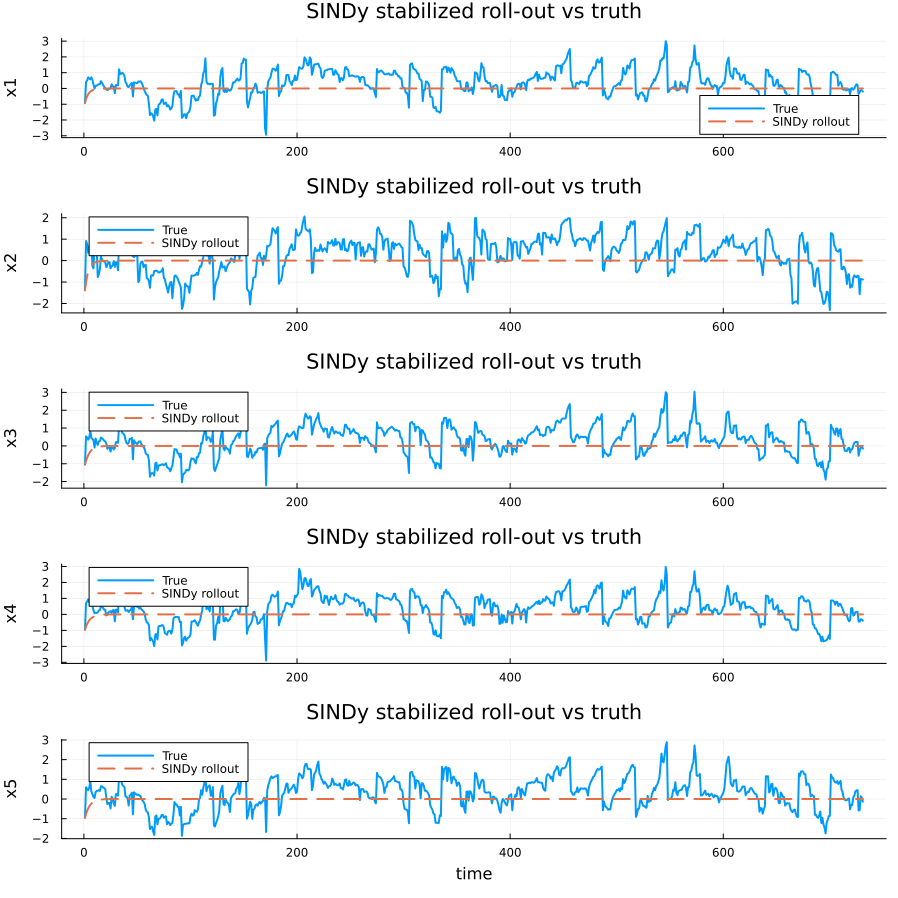

In [13]:
# 1st plot
gr()
modesToPlot = 1:5
t = 1:size(ZRollout, 2)

p = plot(layout=(length(modesToPlot), 1), size=(900, 900))

for (k, i) in enumerate(modesToPlot)
    plot!(
        p[k],
        t, ZTestN[i, 1:length(t)],
        label="True",
        lw=2
    )
    plot!(
        p[k],
        t, ZRollout[i, :],
        label="SINDy rollout",
        lw=2,
        ls=:dash
    )
    ylabel!(p[k], "x$i")
end

xlabel!(p[end], "time")
plot!(p, title="SINDy stabilized roll-out vs truth")
display(p)